In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.activation import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam


import numpy as np
import matplotlib.pyplot as plt


In [2]:
def build_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    discriminator.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    img = Input(shape=(28, 28, 1))
    probability = discriminator(img)
    return Model(inputs=img, outputs=probability)

In [3]:
def build_generator():
    generator = Sequential()
    generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    generator.add(Reshape((7, 7, 128)))
    generator.add(UpSampling2D())
    generator.add(Conv2D(128, kernel_size=3, padding="same",
                         activation="relu"))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(UpSampling2D())
    # convolutional + batch normalization layers
    generator.add(Conv2D(64, kernel_size=3, padding="same",
                         activation="relu"))
    generator.add(BatchNormalization(momentum=0.8))
    # convolutional layer with filters = 1
    generator.add(Conv2D(1, kernel_size=3, padding="same",
                         activation="relu"))
    generator.summary()
    noise = Input(shape=(100,))
    fake_image = generator(noise)
    return Model(inputs=noise, outputs=fake_image)


In [4]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y] < thresh else 'black')

In [5]:
def train(epochs, discriminator_epochs, batch_size=64, save_interval=50):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(discriminator_epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        print("%d [D loss: %f, acc.: %.2f%%] " % (epoch, d_loss[0], 100 * d_loss[1]))
    for epoch in range(epochs):
        # Train the combined network (Generator)
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, valid)
        print("%d [G loss: %f]" % (epoch, g_loss))
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

In [6]:
def plot_generated_images(
        epoch, generator, examples=100, dim=(10, 10),
        figsize=(10, 10)):
    latent_dim = 100
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest',
               cmap='gray_r')
        plt.axis('off')
        plt.tight_layout()
    plt.savefig('gen_images/gan_generated_image_epoch_%d.png' % epoch)

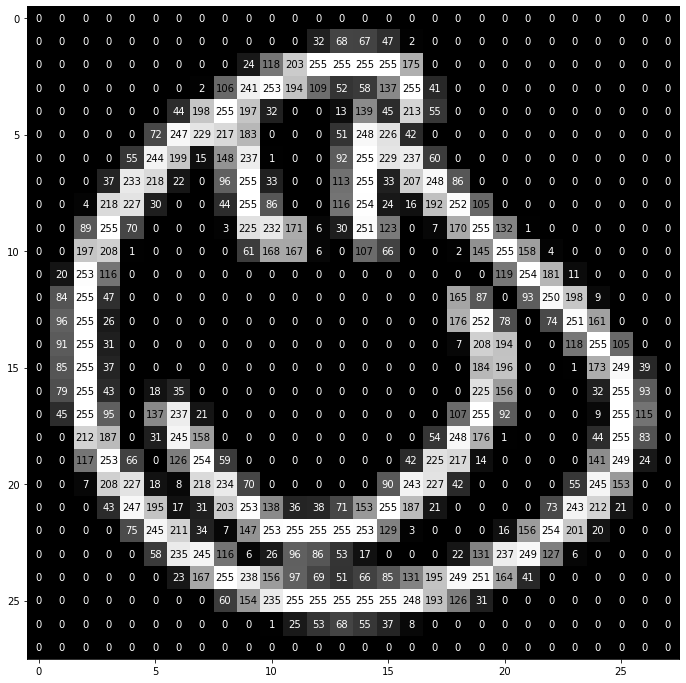

In [7]:
    training_data = np.load('../datasets/full_numpy_bitmap_smiley face.npy')
    training_data = np.array([np.array_split(img_arr, 28) for img_arr in training_data])
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    visualize_input(training_data[0], ax)

In [8]:
X_train = training_data / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
optimizer = Adam(learning_rate=0.0005, beta_1=0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.trainable = False
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)
valid = discriminator(img)
combined = Model(inputs=z, outputs=valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 128)     

In [9]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
train(1000, 200)

2/2 [==============================] - 0s 46ms/step
0 [D loss: 1.661458, acc.: 31.25%] 
2/2 [==============================] - 0s 46ms/step
1 [D loss: 0.111002, acc.: 99.22%] 
2/2 [==============================] - 0s 37ms/step
2 [D loss: 0.028553, acc.: 100.00%] 
2/2 [==============================] - 0s 53ms/step
3 [D loss: 0.016217, acc.: 100.00%] 
2/2 [==============================] - 0s 49ms/step
4 [D loss: 0.010652, acc.: 100.00%] 
2/2 [==============================] - 0s 42ms/step
5 [D loss: 0.008960, acc.: 100.00%] 
2/2 [==============================] - 0s 39ms/step
6 [D loss: 0.005593, acc.: 100.00%] 
2/2 [==============================] - 0s 40ms/step
7 [D loss: 0.006628, acc.: 100.00%] 
2/2 [==============================] - 0s 68ms/step
8 [D loss: 0.004146, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
9 [D loss: 0.005130, acc.: 100.00%] 
2/2 [==============================] - 0s 45ms/step
10 [D loss: 0.003665, acc.: 100.00%] 
2/2 [=================

2/2 [==============================] - 0s 41ms/step
91 [D loss: 0.000108, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
92 [D loss: 0.000115, acc.: 100.00%] 
2/2 [==============================] - 0s 37ms/step
93 [D loss: 0.000104, acc.: 100.00%] 
2/2 [==============================] - 0s 39ms/step
94 [D loss: 0.000103, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
95 [D loss: 0.000106, acc.: 100.00%] 
2/2 [==============================] - 0s 39ms/step
96 [D loss: 0.000105, acc.: 100.00%] 
2/2 [==============================] - 0s 48ms/step
97 [D loss: 0.000115, acc.: 100.00%] 
2/2 [==============================] - 0s 37ms/step
98 [D loss: 0.000121, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
99 [D loss: 0.000166, acc.: 100.00%] 
2/2 [==============================] - 0s 39ms/step
100 [D loss: 0.000112, acc.: 100.00%] 
2/2 [==============================] - 0s 39ms/step
101 [D loss: 0.000113, acc.: 100.00%] 
2/2 [===

2/2 [==============================] - 0s 36ms/step
181 [D loss: 0.000047, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
182 [D loss: 0.000035, acc.: 100.00%] 
2/2 [==============================] - 0s 43ms/step
183 [D loss: 0.000039, acc.: 100.00%] 
2/2 [==============================] - 0s 37ms/step
184 [D loss: 0.000041, acc.: 100.00%] 
2/2 [==============================] - 0s 37ms/step
185 [D loss: 0.000052, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
186 [D loss: 0.000038, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
187 [D loss: 0.000027, acc.: 100.00%] 
2/2 [==============================] - 0s 37ms/step
188 [D loss: 0.000034, acc.: 100.00%] 
2/2 [==============================] - 0s 44ms/step
189 [D loss: 0.000047, acc.: 100.00%] 
2/2 [==============================] - 0s 43ms/step
190 [D loss: 0.000069, acc.: 100.00%] 
2/2 [==============================] - 0s 41ms/step
191 [D loss: 0.000037, acc.: 100.00%] 